## Atmospheric effects on Ground Based Telescope Observing Bands
This notebook uses a python script to calculate and plot CMB instrument sensitivity to fluctuations in atmospheric pwv, given band shapes.

In [1]:
##### import matplotlib.pyplot as plt
#edit
import numpy as np
import matplotlib.pyplot as plt
import yaml

from Atmos_pwv_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 6]

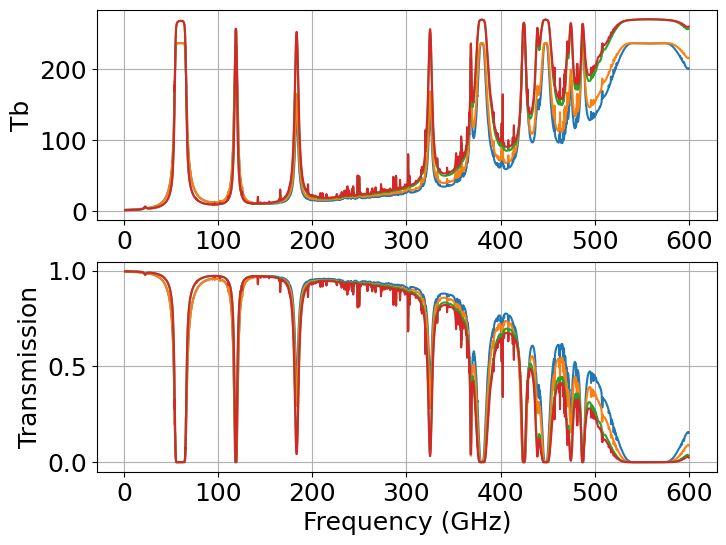

In [2]:
# Read in atmospheric data, plot it to see that it makes sense.
atmos = {}
read_atmospheres(atmos)
plt.subplot(2,1,1)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][1])
plt.ylabel('Tb')
plt.grid()

plt.subplot(2,1,2)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.grid()

# Outline

*We've been using jbolo to facilitate the calculation of g_pwv because it then includes all the frequency 
dependence of the optics and the atmophsere.  The major frequency-dependent component of the optics is the 
Lyot stop.  We can treat the problem more generally by considering two designs, for two limits of Lyot-stop
illumination.*

1. Calculate single-moded, single-polarization instrument band response, ie to atmosphere.
  - F_inst($\nu$) = F_detector($\nu$) \* F_lyot($\nu$)
  - F_detector($\nu$) from logistic detector band
  - F_lyot($\nu$) depends on amount of spillover:
    - low spill Lyot stop => nearly frequency independent.
    - high spill lyot stop => efficiency of that is \propto nu^2
  
  
2. Integrate Tb_atmos($\nu$) over F_inst($\nu$) to get dPopt_atmosphere/dpwv.


3. Calculate response to delta_T_cmb
  - F_tot($\nu$) = F_inst($\nu$) * F_atmos($\nu$)
  - Integrate delta_T_cmb over F_tot($\nu$) to get dPopt_cmb/dT_cmb
  
  
4. Take the ratio of those two, g_pwv = (dPopt_atmosphere/dpwv)/(dPopt_cmb/dT_cmb) = dT_cmb/dpwv .

# Read in band information from a yaml file
(using same dictionary format as jbolo, for compatibility)

In [3]:
sim = yaml.safe_load(open('channels.yaml'))

In [4]:
sim['channels']

{'ULF': {'chnum': 0, 'band_center': 20.0, 'nu_low': 17.5, 'nu_high': 22.5},
 'LF_1': {'chnum': 1, 'band_center': 25.75, 'nu_low': 21.5, 'nu_high': 30.0},
 'LF_2': {'chnum': 2, 'band_center': 38.75, 'nu_low': 29.99, 'nu_high': 47.51},
 'MF_1': {'chnum': 3, 'band_center': 91.5, 'nu_low': 77.0, 'nu_high': 106.0},
 'MF_2': {'chnum': 4, 'band_center': 148.5, 'nu_low': 128.0, 'nu_high': 169.0},
 'HF_1': {'chnum': 5,
  'band_center': 227.0,
  'nu_low': 197.94,
  'nu_high': 256.06},
 'HF_2': {'chnum': 6,
  'band_center': 285.5,
  'nu_low': 255.95,
  'nu_high': 315.05}}

8.5


Text(0.5, 1.0, 'Model LF1 Band')

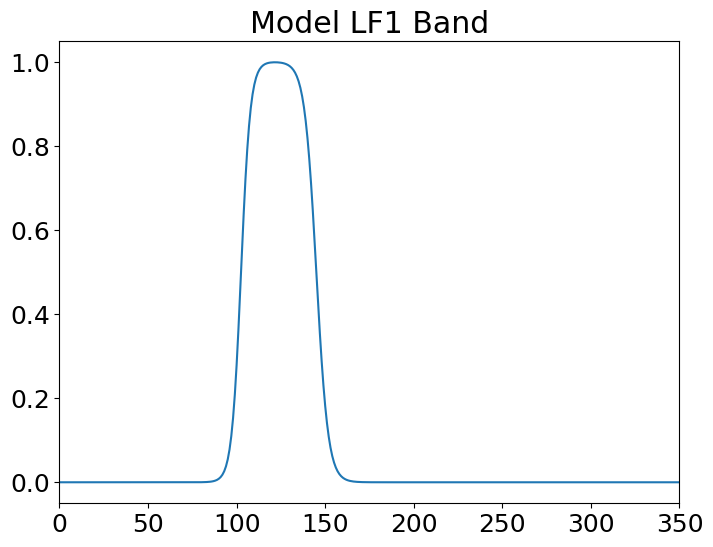

In [5]:
dnu= sim['channels']['LF_1']['nu_high']-sim['channels']['LF_1']['nu_low']
print(dnu)
model1=logistic_bandmodel(atmos['Pole'][300][0], sim['channels']['LF_1']['band_center'], dnu, 2, 0.7)

plt.plot(model1)
plt.xlim(0,350)
plt.title('Model LF1 Band')

Comment on plot above:

- we might want to make band smaller for LF so we are not integrating over the whole thing (all freq)

In [41]:
dpdtcmb= calc_dPdTcmb(atmos['Pole'][300][0], atmos['Pole'][400][0], sim['channels']['LF_1']['band_center'], dnu, 2, 0.7, 2)
print('dPdTcmb:', dpdtcmb)

dPdTcmb: 2.3575717163473365e-13


In [40]:
dPdpwv= calc_dPdpwv(atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], sim['channels']['LF_1']['band_center'], dnu, 2, 0.7, 2)
print('dPdpwv:', dPdpwv)

model: [1.50815345e-08 2.17174097e-08 2.95598077e-08 ... 5.42211571e-03
 5.42573347e-03 5.42935244e-03]
Patm0 4.9741545330941674e-12
Patm1: 5.24884076783603e-12
dPdpwv: 2.7468623474186294e-12


In [42]:
gpwv= calc_gpwv(dPdpwv, dpdtcmb)
print('gpwv:', gpwv)

gpwv: 11.6512355843598


Given the results, the functions seem to be working well. We need to review them again to see if we're missing anything in regard to the lyot/optics.

In [48]:
#this section visualizes the alpha bandmodel function, play with the alpha parameter (0 or 2)
band=alpha_bandmodel(atmos['Pole'][300][0], sim['channels']['LF_1']['band_center'], 2)

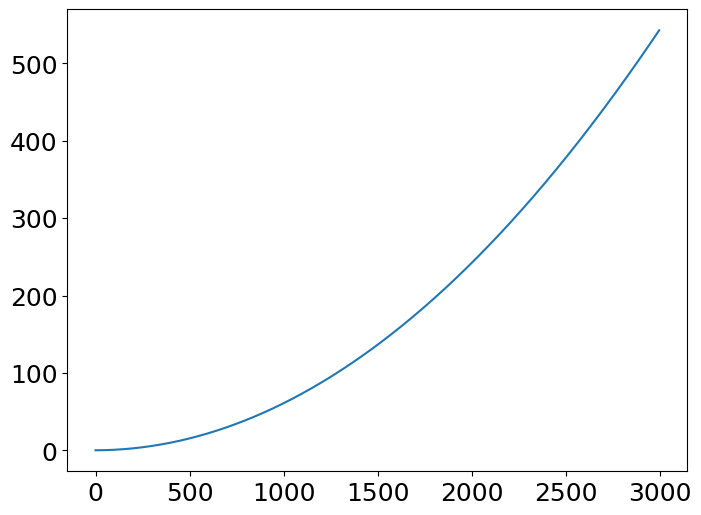

In [49]:
plt.plot(band)

## Calculate and save gpwv values through all bands 
The following cells take portion of previous nbs and calculate gpwv values for each band and then save them into a dictionary where they can be called to plot.

In [62]:
#South Pole Dict
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
spole_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Pole'].keys():
    spole_dict[pwv]={}
    for ch in chlist:
        spole_dict[pwv][ch]={}
        dnu = sim['channels'][ch]['nu_high']-sim['channels'][ch]['nu_low']
        nu0 = sim['channels'][ch]['band_center']
        dPdpwv = calc_dPdpwv(atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Pole'][300][0], atmos['Pole'][400][0], nu0, dnu, a, n, alpha)
        gpwv= dPdpwv/dPdTcmb
    

        spole_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        spole_dict[pwv][ch]['dPdpwv']= dPdpwv
        spole_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)

In [64]:
spole_dict[300]

{'ULF': {'dPdTcmb': 1.4293299644938578e-13,
  'dPdpwv': 4.348983232192578e-12,
  'gpwv': 30.42672678965772},
 'LF_1': {'dPdTcmb': 2.3575717163473365e-13,
  'dPdpwv': 2.7468623474186294e-12,
  'gpwv': 11.6512355843598},
 'LF_2': {'dPdTcmb': 4.737064885283379e-13,
  'dPdpwv': 1.323901314902397e-12,
  'gpwv': 2.794771334070927},
 'MF_1': {'dPdTcmb': 6.464302401407357e-13,
  'dPdpwv': 1.8476713696785205e-12,
  'gpwv': 2.8582687735590158},
 'MF_2': {'dPdTcmb': 6.490388184340165e-13,
  'dPdpwv': 9.149937450561197e-12,
  'gpwv': 14.097673653230668},
 'HF_1': {'dPdTcmb': 4.741675657186194e-13,
  'dPdpwv': 2.6336826056432956e-11,
  'gpwv': 55.543288829801064},
 'HF_2': {'dPdTcmb': 2.648064871343984e-13,
  'dPdpwv': 4.711174458153035e-11,
  'gpwv': 177.91008479946913}}

In [66]:
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
atacama_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Atacama'].keys():
    atacama_dict[pwv]={}
    for ch in chlist:
        atacama_dict[pwv][ch]={}
        dnu = sim['channels'][ch]['nu_high']-sim['channels'][ch]['nu_low']
        nu0 = sim['channels'][ch]['band_center']
        dPdpwv = calc_dPdpwv(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], nu0, dnu, a, n, alpha)
        gpwv= dPdpwv/dPdTcmb
    

        atacama_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        atacama_dict[pwv][ch]['dPdpwv']= dPdpwv
        atacama_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)

In [67]:
atacama_dict[900]

{'ULF': {'dPdTcmb': 1.4293299644938578e-13,
  'dPdpwv': 1.891642381324531e-12,
  'gpwv': 13.234469494903392},
 'LF_1': {'dPdTcmb': 2.3575717163473365e-13,
  'dPdpwv': 1.2567759723665428e-12,
  'gpwv': 5.3308069640134095},
 'LF_2': {'dPdTcmb': 4.737064885283379e-13,
  'dPdpwv': 6.138770505056357e-13,
  'gpwv': 1.295901714187545},
 'MF_1': {'dPdTcmb': 6.464302401407357e-13,
  'dPdpwv': 1.3043725651009885e-12,
  'gpwv': 2.0178087040250636},
 'MF_2': {'dPdTcmb': 6.490388184340165e-13,
  'dPdpwv': 6.4564226047233975e-12,
  'gpwv': 9.947667876478146},
 'HF_1': {'dPdTcmb': 4.741675657186194e-13,
  'dPdpwv': 1.8688414390173978e-11,
  'gpwv': 39.41310148839674},
 'HF_2': {'dPdTcmb': 2.648064871343984e-13,
  'dPdpwv': 3.244798402423029e-11,
  'gpwv': 122.53470213424879}}

## Plotting
Below is a function for colorbar and contour plotting gpwv values. We need to edit.

In [68]:
def pltgpwv(ch, rownum, colnum):
    gpwvA = out_gpwv_A[ch]*1e3
    gpwv= out_gpwv[ch]*1e3
    minval = np.min(gpwv)
    maxval = np.max(gpwv) #2*minval
    m = gpwv
    x = out_center[ch]
    y = out_width[ch]
    im = axs[rownum,colnum].imshow(m, vmin = minval, vmax=maxval,cmap='rainbow',origin='lower',aspect='auto',interpolation='bilinear', extent=(np.min(out_center[ch]),np.max(out_center[ch]),np.min(out_width[ch]),np.max(out_width[ch])))
    axs[rownum,colnum].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axs[rownum,colnum].transAxes)
    divider = make_axes_locatable(axs[rownum,colnum])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cset = axs[rownum,colnum].contour(x,y,m)#,levels,colors='w')
    axs[rownum,colnum].clabel(cset)#, levels,fmt='%i mK',fontsize=8)
    axs[rownum,colnum].scatter(sim2['channels'][ch]['nu_center'],sim2['channels'][ch]['nu_width'],s=200,marker='x',c='m')
    fig.colorbar(im, cax=cax)
    #plt.show(m)